In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import USCOUNTIES
from matplotlib.lines import Line2D
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import glob
import re
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


<xarray.DataArray 'ptype' (time: 864, latitude: 41, longitude: 53)>
[1877472 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -112.0 -111.8 -111.5 ... -99.5 -99.25 -99.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2011-12-31T23:00:00
Attributes:
    units:      code table (4.201)
    long_name:  Precipitation type

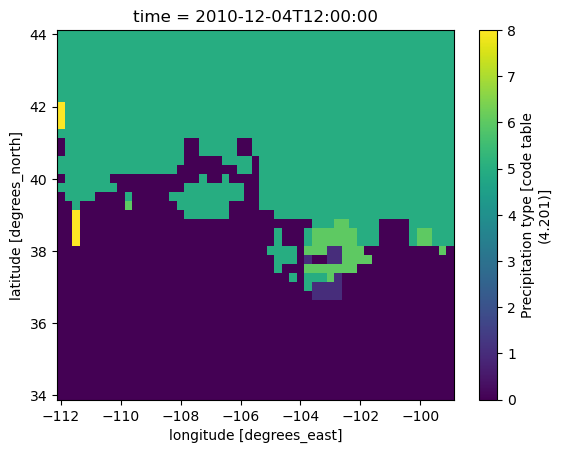

In [2]:
P_types = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precip_Vars_SD/ERA5_sl_precip_SD01_01_2011.nc')
P_types['ptype'][300].plot()
P_types['ptype']

In [3]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_good.csv')
dfmf = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_mf_updated.csv')
dfu = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)
#dfall

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)
dfall_sort

#Organize by Low and High Precipitation Events#
df_LP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_Low_Precip.csv')
df_HP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_High_Precip.csv')

dfall_sort = df_HP.copy()
dfall_sort

,date,max_value,max_time,file_date,total_precip
0,1950-04-04,2286.665639,1950-04-03 22:00:00,1950-04-04,1823.493481
1,1951-02-13,9049.629243,1951-02-12 19:00:00,1951-02-13,1555.739641
2,1951-04-11,1670.024920,1951-04-10 09:00:00,1951-04-11,2396.835327
3,1951-04-21,8806.192719,1951-04-20 22:00:00,1951-04-21,1222.548723
4,1951-10-06,1369.330734,1951-10-05 13:00:00,1951-10-06,3340.264559
...,...,...,...,...,...
140,2018-10-15,16888.019883,2018-10-14 08:00:00,2018-10-15,1124.729514
141,2019-01-23,1613.751993,2019-01-22 07:00:00,2019-01-23,1239.376068
142,2019-04-12,3166.585537,2019-04-11 01:00:00,2019-04-12,1685.142756
143,2020-09-09,16842.581671,2020-09-08 06:00:00,2020-09-09,2057.482004


In [4]:
###Extract the max times so we can use them for compositing###

#Pull out the max time column#
max_times = list(dfall_sort['max_time'].values)
dates = list(dfall_sort['date'].values)
N = len(max_times)

max_times[0:10], print(N)

#Fix the lists#
dates_as_strings = [str(date).split('T')[0] for date in dates]
dates_as_strings[0:5]

145


['1950-04-04', '1951-02-13', '1951-04-11', '1951-04-21', '1951-10-06']

In [43]:
###Make the Precip data function which is similar to the composite code###

def Precip_Data(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag=0, anom=False):
    '''
    Calculates the composite average 2D map for the specified variable and domain.

    Parameters:
    - data_folder: Path to the folder containing the data files.
    - date_list: List of datetime strings in the format 'YYYY-MM-DD HH:MM:SS'.
    - variable: The variable to be analyzed
    - lat_range: Tuple specifying the latitude range (min_lat, max_lat).
    - lon_range: Tuple specifying the longitude range (min_lon, max_lon).
    - time_lag: Time lag in hours to be applied (default is 0).
    '''
    
    #Small function to convert datetime string to filename format#
    def datetime_to_filename(date_str):
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        return f'ERA5_sl_precip_SD{date.month:02d}_{date.day:02d}_{date.year}.nc'  #adjust, name of files to composite 
    
    #Read one file to get the dimensions of latitude and longitude since all will be identical#
    sample_file = os.path.join(data_folder, datetime_to_filename(date_list[5]))
    sample_data = xr.open_dataset(sample_file)
    
    lat = sample_data['latitude']
    lon = sample_data['longitude']
    
    #Find the indices corresponding to the specified latitude and longitude range#
    lat_indices = np.where((lat >= lat_range[0]) & (lat <= lat_range[1]))[0]
    lon_indices = np.where((lon >= lon_range[0]) & (lon <= lon_range[1]))[0]

    #Initialize an empty 3D array to store the data#
    composite_data = np.empty((len(date_list), len(lat_indices), len(lon_indices)))

    #Loop through each case and read the data#
    for i, (date_str, time_str) in enumerate(zip(date_list, time_list)):
        
        #Convert date string to filename#
        filename = datetime_to_filename(date_str)
        file_path = os.path.join(data_folder, filename)
        
        #Read in the data file#
        data = xr.open_dataset(file_path)
        
        #Convert the time string to a datetime object and apply time lag#
        target_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S') + timedelta(hours=time_lag)
        
        #Select the closest time in the dataset#
        time_idx = np.argmin(np.abs(data['time'].values - np.datetime64(target_time)))
        selected_time = data['time'].values[time_idx]
        
        #Extract the variable data for the selected time and within the specified lat-lon range#
        if variable == 'thetaE':
            
            thetaE = calculate_ThetaE(data)
            var_data = thetaE.sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)
            
        elif variable == 'FLF':
            
            thetaE = calculate_ThetaE(data)
            
            FLF_data = xr.apply_ufunc(
                calculate_flf, 
                thetaE, 
                input_core_dims=[['latitude', 'longitude']],  #Core dimensions over which to apply the function
                output_core_dims=[['latitude', 'longitude']], #Core dimensions on the output
                vectorize=True,  #Automatically vectorize the computation if needed
                dask='parallelized',  #Use Dask for parallel computation if thetaE is a Dask-backed array
                kwargs={'dx': dx, 'dy': dy}  #Additional keyword arguments for the function
                )
            FLF_data_n = FLF_data.where(FLF_data < 0, 0)
            
            var_data = FLF_data_n.sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)
            
        else:
               
            var_data = data[variable].sel(time=selected_time).isel(latitude=lat_indices, longitude=lon_indices)  #change for sl or pl
            
            if anom == True:
                
                #Try using the 20-day climos to compute anomalies#
                tofi = pd.to_datetime(selected_time)
                data_path = "/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_sl_LD_vars/"
                file_name = f"{data_path}/climatology_LD_sl_1950-{tofi.month:02d}-{tofi.day:02d} 00:00:00.nc"  #adjust, name of climo files

                if tofi.month == 2 and tofi.day == 29:

                    file_name = f"{data_path}/climatology_LD_sl_1950-03-01 00:00:00.nc"
                    df_climo = xr.open_dataset(file_name)
                    var_data = var_data - df_climo[variable]

                else: 

                    df_climo = xr.open_dataset(file_name)
                    var_data = var_data - df_climo[variable]
            
            else:
                
                var_data = var_data.copy()
                                
        #Extract the coordinates for the composite domain#
        global var_data_lats, var_data_lons
        var_data_lats = var_data['latitude']
        var_data_lons = var_data['longitude']
        
        #Store the data in the array#
        composite_data[i, :, :] = var_data

    #Calculate the composite average along the first axis (CF cases)#
    composite_avg = np.mean(composite_data, axis=0)  #mean or std
    
    print("Done Compositing!")

    return composite_avg, composite_data


#Try an example with t2m#
data_folder = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precip_Vars_SD/'  #may have to edit
date_list = dates_as_strings.copy()
time_list = max_times.copy()
variable = 'ptype'                #any variable in xr (thetaE, FLF too)
lat_range = (34, 44)          #Latitude range (min_lat, max_lat): state of CO with 1 deg buffer #36, -42  
lon_range = (-112, -99)        #Longitude range (min_lon, max_lon): state of CO with 1 deg buffer  #-110, -101
time_lag = 8              #Can either be 0 or negative numbers

precip_avg, precip_data = Precip_Data(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag, anom=False)

Done Compositing!


In [44]:
precip_data.shape

(145, 41, 53)

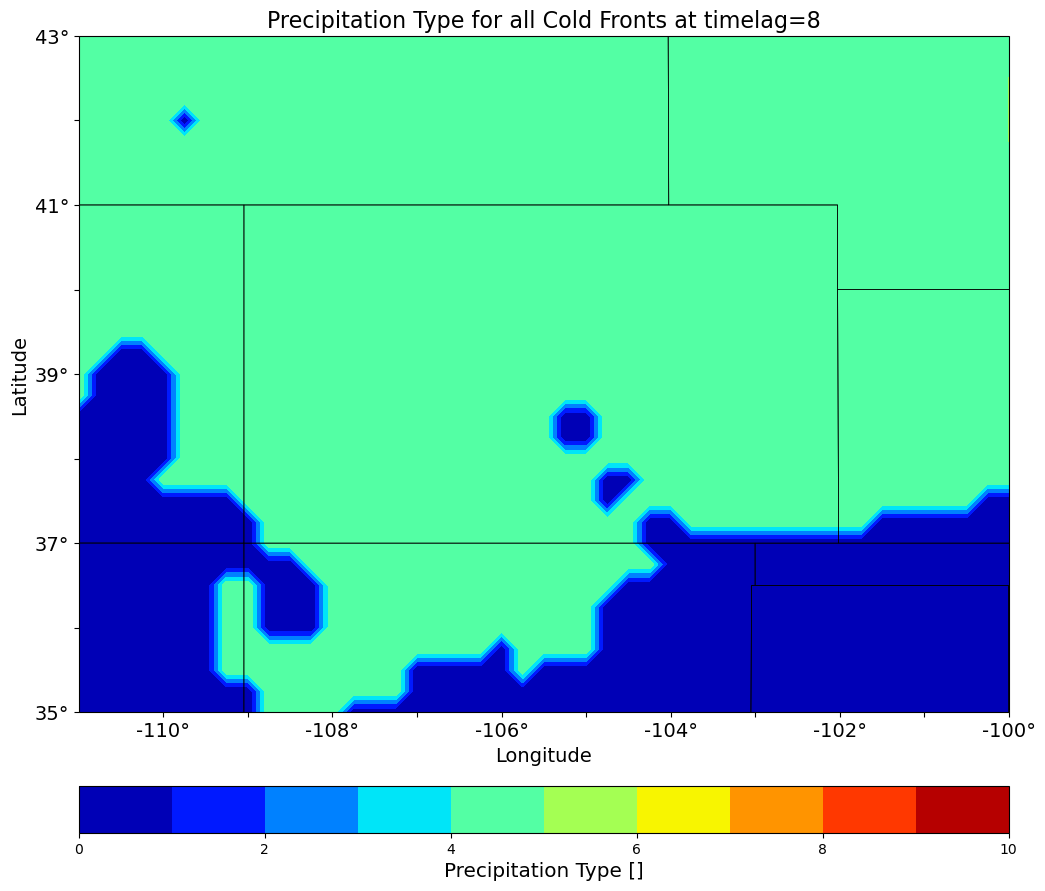

In [45]:
###Plot a single case for Colorado Region###

#Specify a variable and units to plot#
var_of_interest = 'Precipitation Type'
unit_of_interest = ''

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(12, 12)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())  #-110, -100, 35, 43 

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Add the fcontours#
ptype_levels = np.arange(0, 11, 1)
temp_comp_cf = plt.contourf(var_data_lons, var_data_lats, precip_data[144], levels=ptype_levels, cmap="jet", extend='neither', alpha=1, transform=ccrs.PlateCarree())

#Colorbar and contour labels#
cb = fig.colorbar(temp_comp_cf, orientation='horizontal', pad=0.08, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'{var_of_interest} [{unit_of_interest}]', size='x-large') #FLF [K/m^3 * 10^14]

#Fix the lats and lon values#
ax.set_xticks(range(-111, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)

#Plot the longitude and latitude#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(f'{var_of_interest} for all Cold Fronts at timelag={time_lag}', fontsize=16) 

plt.show()

In [46]:
###Obtain the analysis subregion###

binmask = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/binary_mask_T52.nc')
binmask

<xarray.Dataset>
Dimensions:          (latitude: 17, longitude: 14)
Dimensions without coordinates: latitude, longitude
Data variables:
    binary_mask_tcf  (latitude, longitude) bool ...

In [47]:
###Assuming ThetaE_CO has lat/lon dimensions that match the mask##

#Assuming 17 lat points and 14 lon points#
lats_bm = np.linspace(37, 41, 17)  # From 35°N to 43°N
lons_bm = np.linspace(-105.25, -102, 14)  # From -110°W to -100°W

#Assign coordinates explicitly#
binmask_CO = binmask.assign_coords({
    'latitude': ('latitude', lats_bm),
    'longitude': ('longitude', lons_bm)
})

binmask_CO['binary_mask_tcf'].values = np.flipud(binmask_CO['binary_mask_tcf'].values)

binmask_CO

<xarray.Dataset>
Dimensions:          (latitude: 17, longitude: 14)
Coordinates:
  * latitude         (latitude) float64 37.0 37.25 37.5 ... 40.5 40.75 41.0
  * longitude        (longitude) float64 -105.2 -105.0 -104.8 ... -102.2 -102.0
Data variables:
    binary_mask_tcf  (latitude, longitude) bool False False ... False False

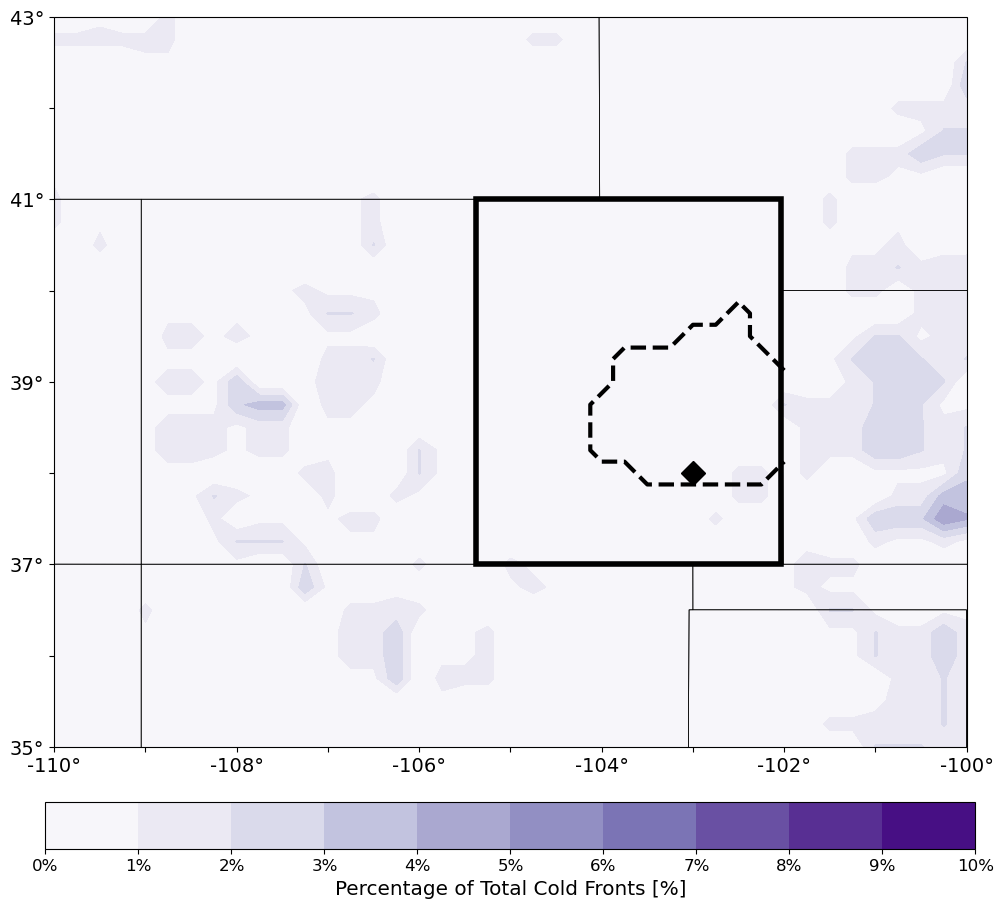

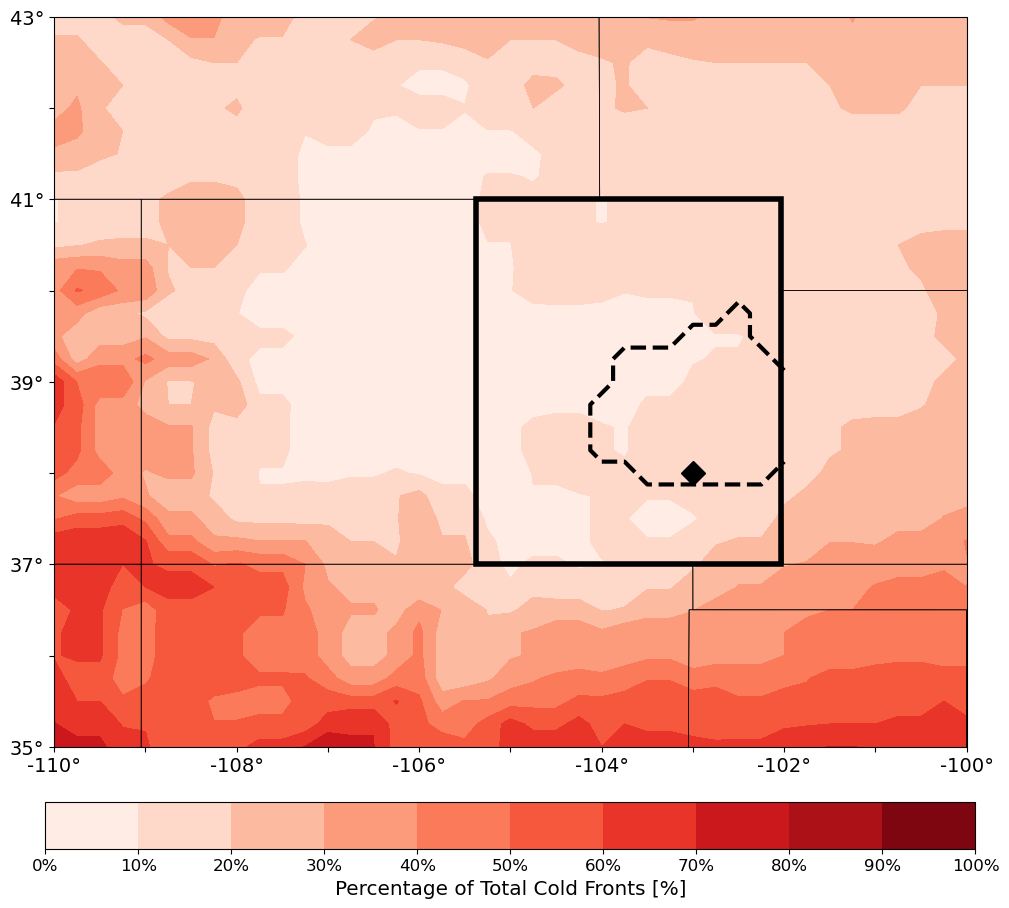

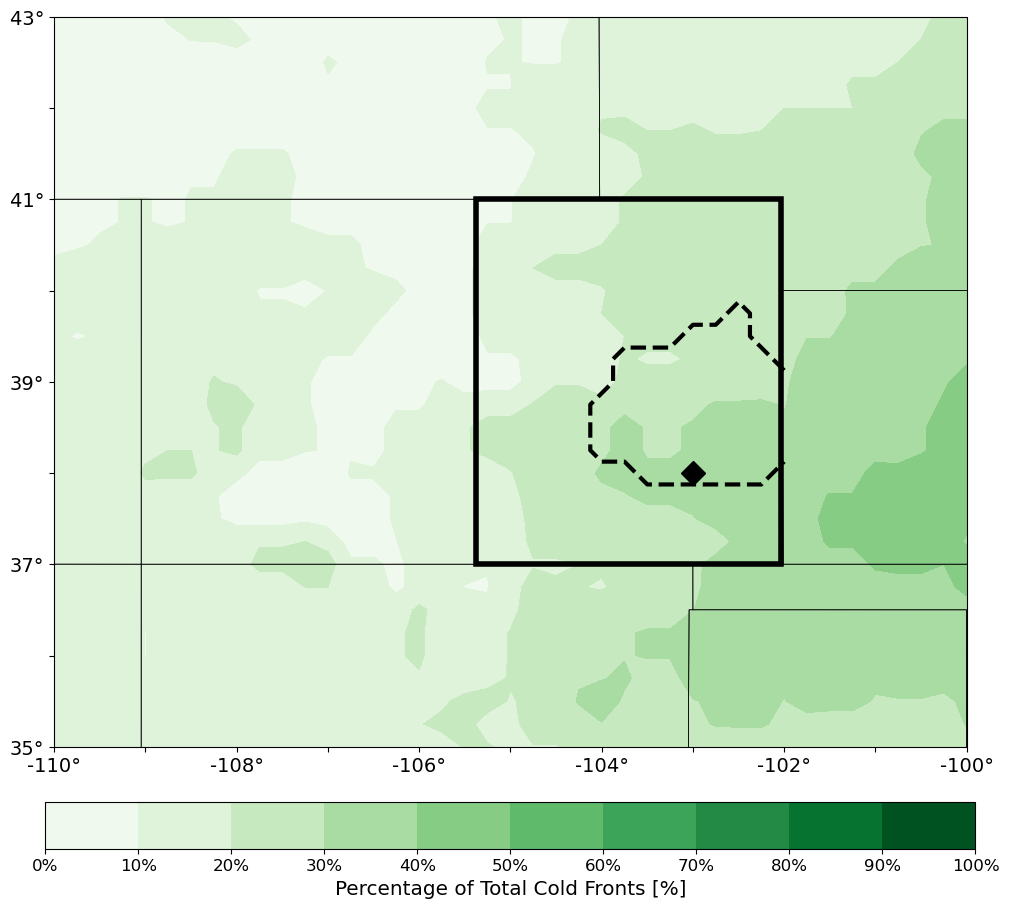

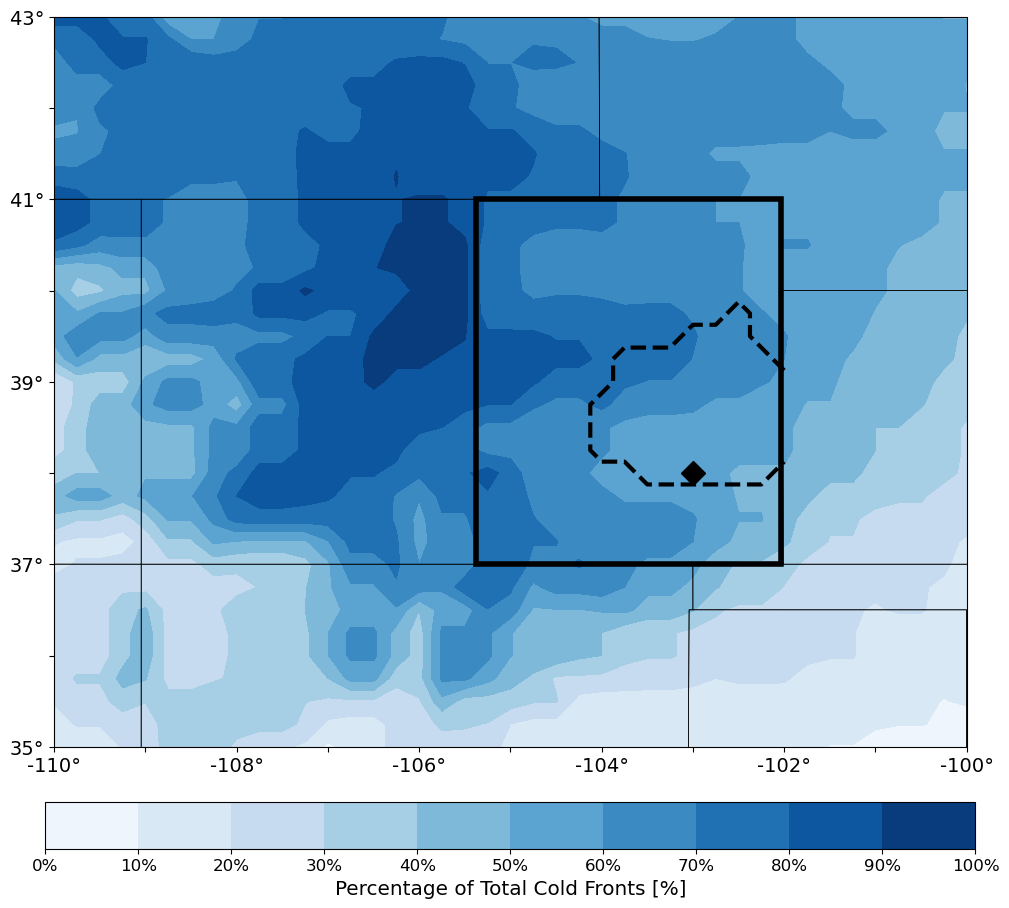

In [48]:
###Now plot the precip type per grid cell###

def pType_plot(ptype_of_interest, precip_df, df_N):
    '''
    Calculates the ptype fraction specified per grid cell.

    Parameters:
    - ptype_of_interest [list]: a list featuring the ptypes you want to plot
    - precip_df [np.array]: the numpy df with the 2D CF data specified
    - df_N [int]: the number of cold fronts in the precip_df
    '''
    
    #Specify some ptype variables need to plot#
    ptype_of_interest = ptype_of_interest.copy() #can take multiple ptype categories#
    tolerance = 0.1  #Define a tolerance level since numbers are not whole

    #Initialize empty 2D array and loop through all CFs and count occurances of the ptype in the tolerance#
    count_array = np.zeros((41, 53))

    for i in range(df_N):

        for ptype in ptype_of_interest:

            count_array += np.abs(precip_df[i] - ptype) < tolerance

    #Calculate the percentage of cold fronts for each grid cell#
    percentage_array = (count_array / df_N) * 100

    #Convert to xr#
    da = xr.DataArray(percentage_array, dims=["lat", "lon"], name="Precipitation_Type_Percentage")

    #Calculate the percentage of cold fronts for each grid cell#
    percentage_array = (count_array / df_N) * 100

    #Convert to xr#
    da = xr.DataArray(percentage_array, dims=["lat", "lon"], name="Precipitation_Type_Percentage")
    
    return da

#Calling the functions for the different precip types#
da_rain = pType_plot([1,2,11], precip_data, 145)
da_mixed = pType_plot([3,4,8,9,10,12], precip_data, 145)
da_snow = pType_plot([5,6,7], precip_data, 145)
da_dry = pType_plot([0], precip_data, 145)


#Plotting#
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())

#ax.set_title('Percentage of HP Fronts Featuring Mixed Precip at time= 8h', fontsize=18)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Colorbar#
cf = ax.contourf(var_data_lons, var_data_lats, da_mixed, levels=np.linspace(0, 10, 11), cmap="Purples", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'Percentage of Total Cold Fronts [%]', size='x-large')
# cb.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# cb.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%'])
cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cb.set_ticklabels(['0%', '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%','10%'])
cb.ax.tick_params(labelsize=12)

#Plot the T52 regions#
binmask_data = binmask_CO['binary_mask_tcf'].values
im3 = ax.contour(binmask_CO.longitude, binmask_CO.latitude, binmask_CO['binary_mask_tcf'], levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=12, color='black', transform=ccrs.PlateCarree()) 

#Create a rectangle patch#
rect = patches.Rectangle((-105.38, 37), 3.35, 4, linewidth=4, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.savefig("Ptype_Mix_HPa8.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()


#Plotting#
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())

#ax.set_title('Percentage of HP Fronts Featuring No Precip at time= 8h', fontsize=18)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Colorbar#
cf = ax.contourf(var_data_lons, var_data_lats, da_dry, levels=np.linspace(0, 100, 11), cmap="Reds", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'Percentage of Total Cold Fronts [%]', size='x-large')
cb.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
cb.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%'])
# cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# cb.set_ticklabels(['0%', '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%','10%'])
cb.ax.tick_params(labelsize=12)

#Plot the T52 regions#
binmask_data = binmask_CO['binary_mask_tcf'].values
im3 = ax.contour(binmask_CO.longitude, binmask_CO.latitude, binmask_CO['binary_mask_tcf'], levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=12, color='black', transform=ccrs.PlateCarree()) 

#Create a rectangle patch#
rect = patches.Rectangle((-105.38, 37), 3.35, 4, linewidth=4, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.savefig("Ptype_Dry_HPa8.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()


#Plotting#
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())

#ax.set_title('Percentage of HP Fronts Featuring Rain at time= 8h', fontsize=18)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Colorbar#
cf = ax.contourf(var_data_lons, var_data_lats, da_rain, levels=np.linspace(0, 100, 11), cmap="Greens", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'Percentage of Total Cold Fronts [%]', size='x-large')
cb.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
cb.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%'])
# cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# cb.set_ticklabels(['0%', '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%','10%'])
cb.ax.tick_params(labelsize=12)

#Plot the T52 regions#
binmask_data = binmask_CO['binary_mask_tcf'].values
im3 = ax.contour(binmask_CO.longitude, binmask_CO.latitude, binmask_CO['binary_mask_tcf'], levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=12, color='black', transform=ccrs.PlateCarree()) 

#Create a rectangle patch#
rect = patches.Rectangle((-105.38, 37), 3.35, 4, linewidth=4, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.savefig("Ptype_Rain_HPa8.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()


#Plotting#
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())

#ax.set_title('Percentage of HP Fronts Featuring Snow at time= 8h', fontsize=18)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Colorbar#
cf = ax.contourf(var_data_lons, var_data_lats, da_snow, levels=np.linspace(0, 100, 11), cmap="Blues", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', pad=0.06, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'Percentage of Total Cold Fronts [%]', size='x-large')
cb.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
cb.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%','100%'])
# cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# cb.set_ticklabels(['0%', '1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%','10%'])
cb.ax.tick_params(labelsize=12)

#Plot the T52 regions#
binmask_data = binmask_CO['binary_mask_tcf'].values
im3 = ax.contour(binmask_CO.longitude, binmask_CO.latitude, binmask_CO['binary_mask_tcf'], levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=12, color='black', transform=ccrs.PlateCarree()) 

#Create a rectangle patch#
rect = patches.Rectangle((-105.38, 37), 3.35, 4, linewidth=4, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.savefig("Ptype_Snow_HPa8.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

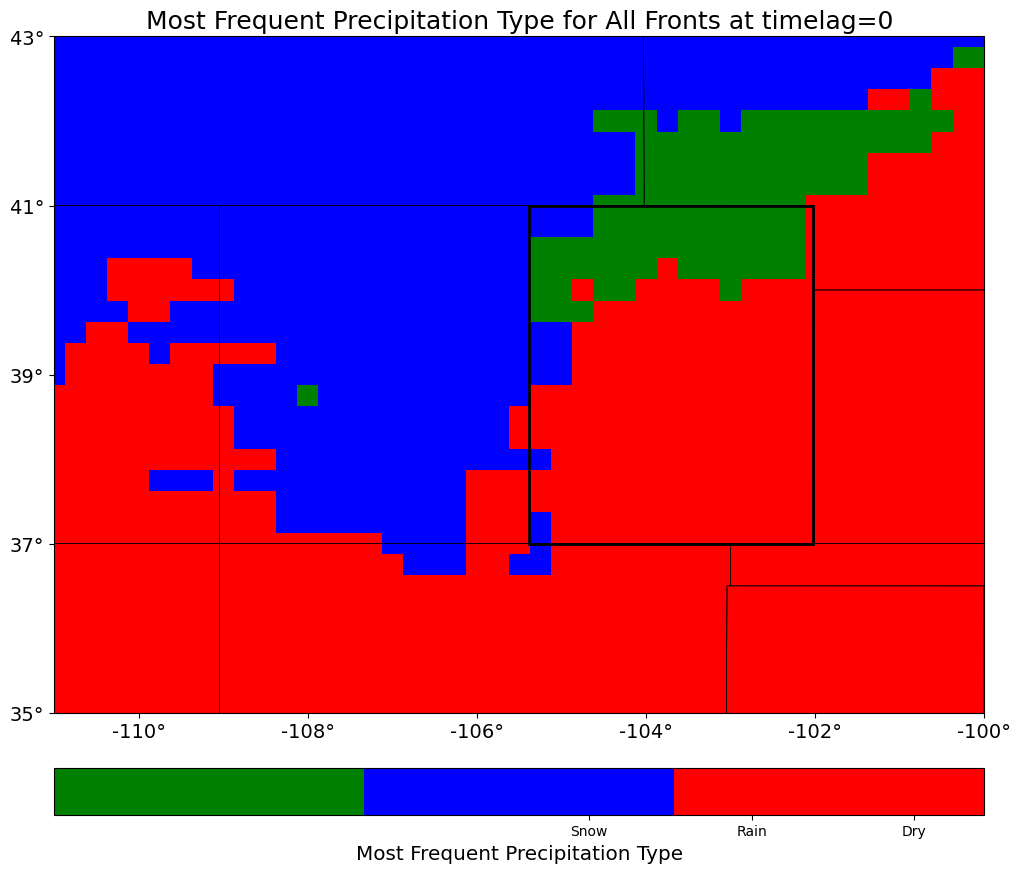

In [42]:
###Make a function to generate the most frequent ptype per grid cell###

def most_frequent_ptype(da_rain, da_snow, da_dry):
    '''
    Determines the most frequent precipitation type per grid cell.

    Parameters:
    - da_rain, da_mixed, da_snow, da_dry: xarray DataArrays containing the percentage of each precip type
    
    Returns:
    - DataArray with the most frequent ptype as a number (e.g., 1 for rain, 2 for snow, 3 for dry)
    '''
    #Stack all the percentages into a single array#
    combined = np.stack([da_rain.values, da_snow.values, da_dry.values], axis=0)
    
    #Find the index of the max value in each grid cell#
    most_frequent_index = np.argmax(combined, axis=0) + 1  # +1 to avoid 0-based index
    
    #Create a new DataArray with the most frequent index#
    da_most_frequent = xr.DataArray(most_frequent_index, dims=["lat", "lon"], name="Most_Frequent_Precipitation_Type")
    
    return da_most_frequent

#Generate the most frequent ptype DataArray#
da_most_frequent = most_frequent_ptype(da_rain, da_snow, da_dry)

#Plotting#
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110, -100, 35, 43], ccrs.PlateCarree())

ax.set_title('Most Frequent Precipitation Type for All Fronts at timelag=0', fontsize=18)
ax.set_xticks(range(-111, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)

#Define the color mapping for each ptype for cmap#
colors = ['green', 'blue', 'red']  
custom_cmap = mcolors.ListedColormap(colors)

mesh = ax.pcolormesh(var_data_lons, var_data_lats, da_most_frequent, cmap=custom_cmap, shading='auto', transform=ccrs.PlateCarree())

#Colorbar#
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.06, aspect=20, shrink=1)
cbar.set_ticks([2.15,2.5, 2.85])
cbar.set_ticklabels(['Snow','Rain', 'Dry'])
cbar.set_label('Most Frequent Precipitation Type', size='x-large')

#Add aditional stuff#
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

rect = patches.Rectangle((-105.38, 37), 3.35, 4, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

#plt.savefig("FreqPrecipType_All.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [34]:
###Figuring out file overlap for composite figs###

#Lists of file names in directory#
left_files = glob.glob('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/ThetaE_LD/ERA5_sl_thetaE_LD_*.nc')

#The true CF dates#
right_files = glob.glob('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_*.nc')

#Function to extract dates from filenames#
def extract_date_from_filename(filename, pattern):
    
    match = re.search(pattern, filename)
    
    if match:
        return match.group()
    
    return None

#Define regex patterns for the two formats#
left_pattern = r'\d{2}_\d{2}_\d{4}'
right_pattern = r'\d{2}_\d{2}_\d{4}'

#Extract dates from the file names#
left_dates = [extract_date_from_filename(f, left_pattern) for f in left_files]
right_dates = [extract_date_from_filename(f, right_pattern) for f in right_files]

#Convert lists to pandas DataFrames for easier comparison#
df_left = pd.DataFrame(left_dates, columns=['Date'])
df_right = pd.DataFrame(right_dates, columns=['Date'])

#Compare the dates between both lists to find discrepancies#
left_only = df_left[~df_left['Date'].isin(df_right['Date'])]
right_only = df_right[~df_right['Date'].isin(df_left['Date'])]

#Print results#
print("Dates only in left files (thetaE):")
print(left_only)

print("Dates only in right files:")
print(right_only)

Dates only in left files (thetaE):
Empty DataFrame
Columns: [Date]
Index: []
Dates only in right files:
Empty DataFrame
Columns: [Date]
Index: []
